In [1]:
import torch
import numpy as np
import pandas as pd
import sklearn.metrics as mt
import matplotlib.pyplot as plt
import datetime

#### 1 数据加载和数据预处理

In [2]:
# 数据集加载 直接在GNN的数据集上修改 保证数据集的一致性
dataset = torch.load('/mnt/yzy/NIMCGCN/new_dataset.pt')
print(dataset.keys())
print(dataset['mm'].keys())
dataset = {
    'md': dataset['md_true'],
    'mm': dataset['mm']['data'],
    'dd': dataset['dd']['data'],
    'fold_one_index': dataset['fold_one_index'],
    'fold_zero_index': dataset['fold_zero_index'],
}
print(dataset.keys())
print(dataset['md'].shape)
print(dataset['mm'].shape)
print(dataset['dd'].shape)
print(dataset['fold_one_index'].shape)
print(dataset['fold_zero_index'].shape)

dict_keys(['md_p', 'md_true', 'mm', 'dd', 'fold_one_index', 'fold_zero_index'])
dict_keys(['data', 'edge_index'])
dict_keys(['md', 'mm', 'dd', 'fold_one_index', 'fold_zero_index'])
torch.Size([1043, 2166])
torch.Size([1043, 1043])
torch.Size([2166, 2166])
torch.Size([10, 2, 143])
torch.Size([10, 2, 225771])


In [4]:
# 转为numpy ndarray
md = dataset['md'].numpy()
mm = dataset['mm'].numpy()
dd = dataset['dd'].numpy()
fold_one_index = dataset['fold_one_index'].numpy()
fold_zero_index = dataset['fold_zero_index'].numpy()
print(md.shape)
print(mm.shape)
print(dd.shape)
print(fold_one_index.shape)
print(fold_zero_index.shape)

(1043, 2166)
(1043, 1043)
(2166, 2166)
(10, 2, 143)
(10, 2, 225771)


#### 2 模型超参和实验设定

In [5]:
# 实验方法 elemment-wise 10-fold cross validation
# 数据划分 0/1元素 均匀划分到各个fold
Kfold = 10      # Kfold 交叉验证数
Kn = 7          # 使用Kn个最相似的邻居信息
dim = 64        # embedding维度
alpha = 0.9     # 使用Kn个最相似的邻居信息的衰减权重
lambdl = 0.5    # 超参数lambda_l 正则化系数
lambdm = 0.001      # 超参数lambda_m miRNA embedding正则化系数
lambdd = 0.001      # 超参数lambda_d Drug embedding正则化系数
threshold = 0.001   # 优化阈值
max_epoch = 30     # 最大迭代次数

mirns = 1043        # miRNA数
drugs = 2166        # Drug数

#### 3 通过节点相似邻居信息，更新关联网络中无边的节点

In [6]:
print(md.shape)
print(len(md.sum(axis=0)))
print(len(md.sum(axis=1)))
empty_drug_col = np.where(md.sum(axis=0) == 0)  # 没有drug信息的列
empty_mir_row = np.where(md.sum(axis=1) == 0)   # 没有miRNA信息的行
print(empty_drug_col[0].shape)  
print(empty_mir_row[0].shape)

empty_drug_col = empty_drug_col[0].tolist()
empty_mir_row = empty_mir_row[0].tolist()

(1043, 2166)
2166
1043
(2031,)
(598,)


In [7]:
alpha_decay = alpha**np.arange(0,Kn)
update_mir_row = np.zeros_like(md)
update_drug_col = np.zeros_like(md)

# 更新全0行 miRNA视角
for i in empty_mir_row:
    # 取出空行miRNA的相似度
    miRNA_sim = mm[i, :]
    miRNA_sim[i] = 0

    # 删除全0行的相似度 全零行对跟新无意义
    miRNA_sim_full = np.delete(miRNA_sim, empty_mir_row)

    # 删除全0行的index
    index = np.arange(0, mirns)
    index_full = np.delete(index, empty_mir_row)


    # 取出相似度最高的Kn个有信息的miRNA
    index_knn = np.argsort(-miRNA_sim_full)[0:Kn]
    index = index_full[index_knn]

    ww = (alpha_decay * miRNA_sim[index]).reshape(Kn,1)
    ym = md[index, :]
    wym = ym*ww
    swym = np.sum(wym,axis=0)
    zm = np.sum(ww)

    if zm == 0:
        ym = 0
    elif zm != 0:
        ym = swym/zm
    
    update_mir_row[i, :] = ym

# 更新全0列 drug视角
for i in empty_drug_col:
    # 取出空列drug的相似度
    drug_sim = dd[i, :]
    drug_sim[i] = 0

    # 删除全0列的相似度 全零列对跟新无意义
    drug_sim_full = np.delete(drug_sim, empty_drug_col)

    # 删除全0列的index
    index = np.arange(0, drugs)
    index_full = np.delete(index, empty_drug_col)


    # 取出相似度最高的Kn个有信息的miRNA
    index_knn = np.argsort(-drug_sim_full)[0:Kn]
    index = index_full[index_knn]

    uu = (alpha_decay * drug_sim[index]).reshape(1,Kn)
    yd = md[:, index]
    wyd = yd*uu
    swyd = np.sum(wyd,axis=1)
    zd = np.sum(uu)

    if zd == 0:
        yd = 0
    elif zd != 0:
        yd = swyd/zd
    
    update_mir_row[:, i] = yd

updata_avg = (update_mir_row + update_drug_col)/2
updated_md = np.maximum(md, updata_avg)

In [8]:
print(updated_md.shape)
print(md.sum(axis=0).sum())
print(updated_md.sum(axis=0).sum())

print("原有Drug{:5d}个,更新前无关联信息的Drug{:5d}个,更新后无关联信息的Drug{:3d}个".format(np.array(updated_md.sum(axis=0) == 0).astype(int).shape[0],\
                                                                    len(empty_mir_row),np.array(updated_md.sum(axis=0) == 0).astype(int).sum()))
print("原有miRNA{:5d}个,更新前无关联信息的miRNA{:5d}个,更新后无关联信息的miRNA{:3d}个".format(np.array(updated_md.sum(axis=1) == 0).astype(int).shape[0],\
                                                                       len(empty_drug_col),np.array(updated_md.sum(axis=1) == 0).astype(int).sum()))

(1043, 2166)
1430.0
13272.824
原有Drug 2166个,更新前无关联信息的Drug  598个,更新后无关联信息的Drug  4个
原有miRNA 1043个,更新前无关联信息的miRNA 2031个,更新后无关联信息的miRNA  0个


###　将更新矩阵用于深度学习训练

In [12]:
dataset_mulview = torch.load("../MultiView/multiview_dataset.pt")
print(dataset_mulview.keys())

dict_keys(['md', 'mm_func', 'mm_seq', 'dd_seq', 'dd_mol', 'fold_one_index', 'fold_zero_index'])


In [19]:
dataset_mulview['md_updated'] = torch.from_numpy(updated_md)
print(dataset_mulview.keys())
print(type(dataset_mulview['md_updated']))
print(updated_md.shape)
print(dataset_mulview['fold_one_index'].shape)
print(dataset_mulview['fold_zero_index'].shape)

dict_keys(['md', 'mm_func', 'mm_seq', 'dd_seq', 'dd_mol', 'fold_one_index', 'fold_zero_index', 'md_updated'])
<class 'torch.Tensor'>
(1043, 2166)
torch.Size([10, 2, 143])
torch.Size([10, 2, 225771])


In [22]:
list(updated_md.shape)

[1043, 2166]

In [39]:
print(dataset['md'].sum())
print(fold_one_index[0].shape)
print(dataset['md'][fold_one_index[0][0],fold_one_index[0][1]].sum())
print(dataset['md'][fold_zero_index[0][0],fold_zero_index[0][1]].sum())
print(type(dataset['fold_one_index']))

tensor(1430.)
(2, 143)
tensor(143.)
tensor(0.)
<class 'torch.Tensor'>


In [52]:
train_zero_index = [[],[]]      # x,y
train_nozero_index = [[],[]]    # x,y
train_one_index = [[],[]]       # x,y

xx,yy = updated_md.shape
for i in range(0, xx):
    for j in range(0, yy):
        if updated_md[i,j] == 0:
            train_zero_index[0].append(i)
            train_zero_index[1].append(j)
        elif updated_md[i,j] == 1:
            train_one_index[0].append(i)
            train_one_index[1].append(j)
        else:
            train_nozero_index[0].append(i)
            train_nozero_index[1].append(j)

train_nozero_index = torch.tensor(train_nozero_index,dtype=torch.int)
train_one_index = torch.tensor(train_one_index,dtype=torch.int)
train_zero_index = torch.tensor(train_zero_index,dtype=torch.int)

print(train_nozero_index.shape)
print(train_zero_index.shape)
print(train_one_index.shape)

torch.Size([2, 145422])
torch.Size([2, 2112286])
torch.Size([2, 1430])


In [51]:
shuffle_indices_zero = torch.randperm(train_zero_index.shape[1])
shuffle_indices_nozero = torch.randperm(train_nozero_index.shape[1])

shuffled_zero_index = train_zero_index[:,shuffle_indices_zero]
shuffled_nozero_index = train_nozero_index[:,shuffle_indices_nozero]


print(shuffled_zero_index.shape,shuffled_nozero_index.shape)
shuffled_zero_index = torch.cat((shuffled_zero_index,shuffled_zero_index[:,-4:]),dim=1)
shuffled_nozero_index = torch.cat((shuffled_nozero_index,shuffled_nozero_index[:,-8:]),dim=1)
print(shuffled_zero_index.shape,shuffled_nozero_index.shape)

fold_train_zero_index = torch.split(shuffled_zero_index, int(shuffled_zero_index.shape[1]/10), dim=1)
fold_train_nozero_index = torch.split(shuffled_nozero_index, int(shuffled_nozero_index.shape[1]/10), dim=1)

print(fold_train_zero_index[0].shape, fold_train_nozero_index[0].shape)

torch.Size([2, 2112286]) torch.Size([2, 145422])
torch.Size([2, 2112290]) torch.Size([2, 145430])
torch.Size([2, 211229]) torch.Size([2, 14543])


In [53]:
14543 + 143

14686

In [54]:
fold_train_zero_index_tensor = torch.empty((10,2,211229),dtype=torch.int)
fold_train_nozero_index_tensor = torch.empty((10,2,14686),dtype=torch.int)

for i in range(0,10):
    fold_train_zero_index_tensor[i,:,:] = fold_train_zero_index[i]
    fold_train_nozero_index_tensor[i,:,:] = torch.cat((fold_train_nozero_index[i],dataset['fold_one_index'][i]),dim=1)
print(fold_train_zero_index_tensor.shape, fold_train_nozero_index_tensor.shape)

torch.Size([10, 2, 211229]) torch.Size([10, 2, 14686])


In [55]:
dataset_mulview['fold_train_zero_index'] = fold_train_zero_index_tensor
dataset_mulview['fold_train_nozero_index'] = fold_train_nozero_index_tensor

In [58]:
print(dataset_mulview.keys())

torch.save(dataset_mulview, "../MultiView/multiview_dataset_updatamd.pt")

dict_keys(['md', 'mm_func', 'mm_seq', 'dd_seq', 'dd_mol', 'fold_one_index', 'fold_zero_index', 'md_updated', 'fold_train_zero_index', 'fold_train_nozero_index'])


#### 4 矩阵分解获得节点嵌入

In [8]:
def DiagonalSumMatrix(M):   # 返回矩阵M的对角和矩阵
    rowsum = M.sum(axis=1)
    D = np.diag(rowsum)
    return D

M = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(M)
DiagonalSumMatrix(M) 

[[1 2 3]
 [4 5 6]
 [7 8 9]]


array([[ 6,  0,  0],
       [ 0, 15,  0],
       [ 0,  0, 24]])

In [11]:
def MatrixFactorization(md, mm, dd, index):
    # print("md:",md.shape)
    # print("mm:",mm.shape)
    # print("dd:",dd.shape)
    # print("mirna:",mirns)
    # print("drug:",drugs)
    # print("one_index:",one_index.shape)
    # print("zero_index:",zero_index.shape)
    embedding_mir = np.random.uniform(0, 1, (mirns, dim))       # miRNA embedding   A
    embedding_drug = np.random.uniform(0, 1, (drugs, dim))      # Drug embedding    B

    # print("A:",embedding_mir.shape)
    # print("B:",embedding_drug.shape)

    mm_dm = DiagonalSumMatrix(mm)    # miRNA相似度对角和矩阵    Dm
    dd_dd = DiagonalSumMatrix(dd)    # Drug相似度对角和矩阵    Dd

    # print("Dm:",mm_dm.shape)
    # print("Dd:",dd_dd.shape)
    

    epoch = 1
    while True:
        # embedding_mir_old = np.copy(embedding_mir)
        YB = md@embedding_drug
        ABB = embedding_mir@embedding_drug.T@embedding_drug
        lmSmA = lambdm*mm@embedding_mir
        llA = lambdl*embedding_mir
        lmDmA = lambdm*mm_dm@embedding_mir
        mm_numerator = YB + lmSmA
        mm_denominator = ABB + llA + lmDmA 
        
        # embedding_drug_old = np.copy(embedding_drug)
        YA = md.T@embedding_mir
        BAA = embedding_drug@embedding_mir.T@embedding_mir
        ldSdB = lambdm*dd@embedding_drug
        llB = lambdl*embedding_drug
        ldDdB = lambdm*dd_dd@embedding_drug
        dd_numerator = YA + ldSdB
        dd_denominator = BAA + llB + ldDdB

        for i in range(0, mirns):
            for j in range(0, dim):
                if mm_denominator[i, j] == 0:
                    embedding_mir[i, j] = 0
                else:
                    embedding_mir[i, j] *= mm_numerator[i, j]/mm_denominator[i, j]
        # embedding_mir_diff = np.absolute(embedding_mir - embedding_mir_old)
        
        for i in range(0, drugs):
            for j in range(0, dim):
                if dd_denominator[i, j] == 0:
                    embedding_drug[i, j] = 0
                else:
                    embedding_drug[i, j] *= dd_numerator[i, j]/dd_denominator[i, j]
        # embedding_drug_diff = np.absolute(embedding_drug - embedding_drug_old)

        Ystar = embedding_mir@embedding_drug.T
        Y_diff = np.absolute(Ystar - md)[index[0],index[1]] # 取出训练集的loss

        if epoch % 10 == 0:
            print("epoch {}: elem average loss = {:4.8f}, max diff = {:4.8f}".format(epoch, Y_diff.sum()/(mirns*drugs), Y_diff.max()))        
        if Y_diff.max() < threshold or epoch > max_epoch:
            break
        epoch += 1
        # if (np.max(embedding_mir_diff) < threshold and np.max(embedding_drug_diff) < threshold) or epoch > 500:
        #     break
            
    return embedding_mir, embedding_drug, embedding_mir@embedding_drug.T
        
# A,B,Ystar = MatrixFactorization(md, mm, dd)

#### 5 交叉验证并评估模型

In [12]:
label_pred = np.empty((mirns, drugs))
for i in range(0, Kfold):
    print("__________Fold {:2d}__________".format(i+1))

    train_elem_one_index = np.concatenate(([fold_one_index[j] for j in range(0,Kfold) if j != i]), axis=1)
    train_elem_zero_index = np.concatenate(([fold_zero_index[j] for j in range(0,Kfold) if j != i]), axis=1)
    
    train_elem_index = np.concatenate((train_elem_one_index, train_elem_zero_index), axis=1)
    val_elem_index = np.concatenate((fold_one_index[i], fold_zero_index[i]), axis=1)

    A,B,Ystar = MatrixFactorization(updated_md, mm, dd, train_elem_index)
    label_pred[val_elem_index[0], val_elem_index[1]] = Ystar[val_elem_index[0], val_elem_index[1]]

    score = mt.roc_auc_score(md[val_elem_index[0], val_elem_index[1]], label_pred[val_elem_index[0], val_elem_index[1]])
    print("Fold {:2d} auc score: {:4.8f}".format(i+1, score))

__________Fold  1__________
epoch 10: elem average loss = 0.00605348, max diff = 0.99999621
epoch 20: elem average loss = 0.00402023, max diff = 0.99998407
epoch 30: elem average loss = 0.00306944, max diff = 1.02462510
Fold  1 auc score: 0.99627220
__________Fold  2__________
epoch 10: elem average loss = 0.00593270, max diff = 0.99999631
epoch 20: elem average loss = 0.00394089, max diff = 0.99997581
epoch 30: elem average loss = 0.00292507, max diff = 0.99988785
Fold  2 auc score: 0.99767095
__________Fold  3__________
epoch 10: elem average loss = 0.00591986, max diff = 0.99999663
epoch 20: elem average loss = 0.00412114, max diff = 0.99995347
epoch 30: elem average loss = 0.00306815, max diff = 0.99992741
Fold  3 auc score: 0.99661366
__________Fold  4__________
epoch 10: elem average loss = 0.00608845, max diff = 0.99999627
epoch 20: elem average loss = 0.00410840, max diff = 0.99998199
epoch 30: elem average loss = 0.00313195, max diff = 0.99995303
Fold  4 auc score: 0.99735077


36455 0.016136685762445677
Best threshold: 0.09
0.9951840037388745


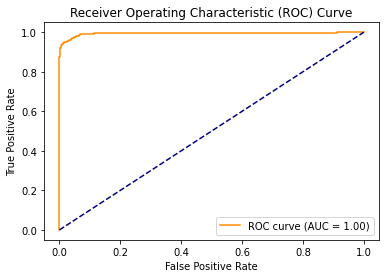

In [15]:
score = label_pred.reshape(-1)
label = md.reshape(-1)

fpr, tpr, thresholds = mt.roc_curve(label, score)
best_idx = np.argmax(tpr - fpr)
best_threshold = thresholds[best_idx]

# 将模型输出映射为二分类标签
prediction = (score >= best_threshold).astype(int)
print(sum(prediction),sum(prediction)/2259138)
print(f'Best threshold: {best_threshold:.2f}')
# 计算 AUC
roc_auc = mt.auc(fpr, tpr)
print(roc_auc)
# 绘制 ROC 曲线
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

0.884318792489077


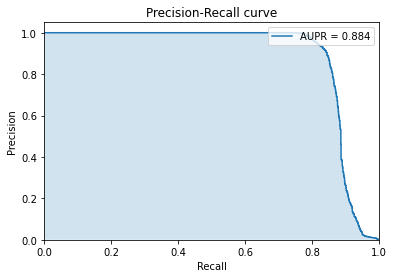

In [16]:
precision, recall, thresholds = mt.precision_recall_curve(label, score)
aupr = mt.auc(recall, precision)
print(aupr)
plt.plot(recall, precision, label='AUPR = %.3f' % aupr)
plt.fill_between(recall, precision, alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.legend(loc='upper right')
plt.show()

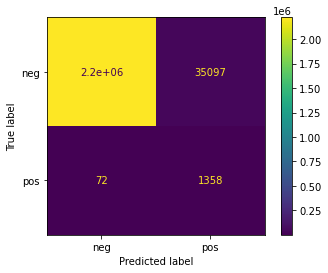

In [17]:
cm = mt.confusion_matrix(label,prediction)
disp = mt.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neg','pos'])
disp.plot()
plt.show()

In [ ]:
today = datetime.date.today().strftime("%Y%m%d")[2:]
np.save('/mnt/yzy/NIMCGCN/Prediction/MF/NMF_KNN_{}fold_{}.ipynb'.format(Kfold, today), score)